# Hurricane Path Prediction Phase 2

In this project, we'll be using data mining algorithms to predict the hurricane's path.

## Get the Data
We're using data from 1920 to 2020 for training our model.

In [1]:
# ALL THE IMPORTS NECESSARY
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import great_circle as vc
import math as Math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
# Importing layers directly from keras.layers
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM # LSTM is also now imported directly from keras.layers
import math, time
from keras.models import model_from_json

In [2]:
data = pd.read_csv('/content/hurricane_data_1920_2020.csv', index_col=None, names=['Year', 'Month', 'Day', 'Hour', 'HurricaneNum', 'Name', 'Lat', 'Long', 'WindSpeed', 'Pressure'])
# Create a unique key for all of the hurricane
data['unique-key'] = data['Name'] + '-' + data['Year'].map(str) + '-' + data['HurricaneNum'].map(str)
# Delete the columns of information that we are not using so far
data.drop(['Name', 'HurricaneNum', 'Year'], axis = 1, inplace = True)
# Preview the first 5 rows of data
data.head()

Month  Day  Hour   Lat  Long  WindSpeed  Pressure            unique-key
0      5   16    18    28 -78.7       30.0      1008  ARTHUR-2020-AL012020
1      5   17     0  28.9 -78.0       35.0      1006  ARTHUR-2020-AL012020
2      5   17     6  29.6 -77.6       35.0      1004  ARTHUR-2020-AL012020
3      5   17    12  30.3 -77.5       35.0      1003  ARTHUR-2020-AL012020
4      5   17    18    31 -77.3       40.0      1003  ARTHUR-2020-AL012020

In [3]:
# Remove hurricanes where pressure = 0
data = data[data['Pressure'] != 0]
data.head()

Month  Day  Hour   Lat  Long  WindSpeed  Pressure            unique-key
0      5   16    18    28 -78.7       30.0      1008  ARTHUR-2020-AL012020
1      5   17     0  28.9 -78.0       35.0      1006  ARTHUR-2020-AL012020
2      5   17     6  29.6 -77.6       35.0      1004  ARTHUR-2020-AL012020
3      5   17    12  30.3 -77.5       35.0      1003  ARTHUR-2020-AL012020
4      5   17    18    31 -77.3       40.0      1003  ARTHUR-2020-AL012020

In [4]:
# Total amount of hurricanes we have in our dataset
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

1142


In [5]:
# Finding errors in CSV
print(data[data['Lat'].str.contains("NAMED")])
data = data[~data['Lat'].str.contains("NAMED")]

       Month  Day  Hour    Lat  Long  WindSpeed  Pressure   unique-key
16350      8   31    12  NAMED  37.1      -64.3        25  NOT-2011-20
16351      8   31    18  NAMED  37.1      -64.1        25  NOT-2011-20
16352      9    1     0  NAMED  37.3      -63.9        25  NOT-2011-20
16353      9    1     6  NAMED  37.4      -63.7        30  NOT-2011-20
16354      9    1    12  NAMED  37.4      -63.7        40  NOT-2011-20
16355      9    1    18  NAMED  37.4      -63.8        35  NOT-2011-20
16356      9    2     0  NAMED  37.5      -63.8        35  NOT-2011-20
16357      9    2     6  NAMED  37.8      -63.7        40  NOT-2011-20
16358      9    2    12  NAMED  38.0      -62.8        40  NOT-2011-20
16359      9    2    18  NAMED  39.0      -61.8        35  NOT-2011-20
16360      9    3     0  NAMED  40.0      -60.7        30  NOT-2011-20
16361      9    3     6  NAMED  41.0      -59.9        30  NOT-2011-20
16362      9    3    12  NAMED  42.0      -59.2        30  NOT-2011-20
16363 

In [6]:
# Total amount of hurricanes we have in our dataset
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

1141


In [7]:
# Since our keys are strings, we enumerate them to access them as integers
keys = list(enumerate(pd.unique(data['unique-key'])))
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))

# Now contains how many time instances of data (or rows) each hurricane contains
hurricane_amount = pd.DataFrame(y)

1141


In [8]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

# Provides statistical information about the DataFrame
hurricane_amount.describe()

Top 6 Hurricanes (in terms of data quantity)
NADINE-2012-AL142012 - 96.0
NADINE-2012-14 - 96.0
IVAN-2004-9 - 94.0
KYLE-2002-12 - 90.0
LESLIE-2018-AL132018 - 89.0
KYLE-2002-AL122002 - 88.0


0
count  1141.000000
mean     23.441718
std      19.043288
min       1.000000
25%       8.000000
50%      19.000000
75%      33.000000
max      96.000000

In [9]:
cond = (hurricane_amount > 6) & (hurricane_amount < 60)
keys25 = []

for x in cond.index:
    if cond.loc[x][0]:
        keys25.append(keys[x][1])

word2keys = {}
for x in keys:
    word2keys[x[1]] = x[0]

data = data[data['unique-key'].isin(keys25)]
keys = list(enumerate(pd.unique(data['unique-key'])))
data.head()

Month  Day  Hour   Lat  Long  WindSpeed  Pressure            unique-key
0      5   16    18    28 -78.7       30.0      1008  ARTHUR-2020-AL012020
1      5   17     0  28.9 -78.0       35.0      1006  ARTHUR-2020-AL012020
2      5   17     6  29.6 -77.6       35.0      1004  ARTHUR-2020-AL012020
3      5   17    12  30.3 -77.5       35.0      1003  ARTHUR-2020-AL012020
4      5   17    18    31 -77.3       40.0      1003  ARTHUR-2020-AL012020

In [10]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of data quantity)
UNNAMED-2011-AL202011 - 96.0
TANYA-1995-21 - 96.0
ERIN-2007-5 - 94.0
KATRINA-2005-12 - 90.0
FOUR-2017-AL042017 - 89.0
FELIX-2001-7 - 88.0


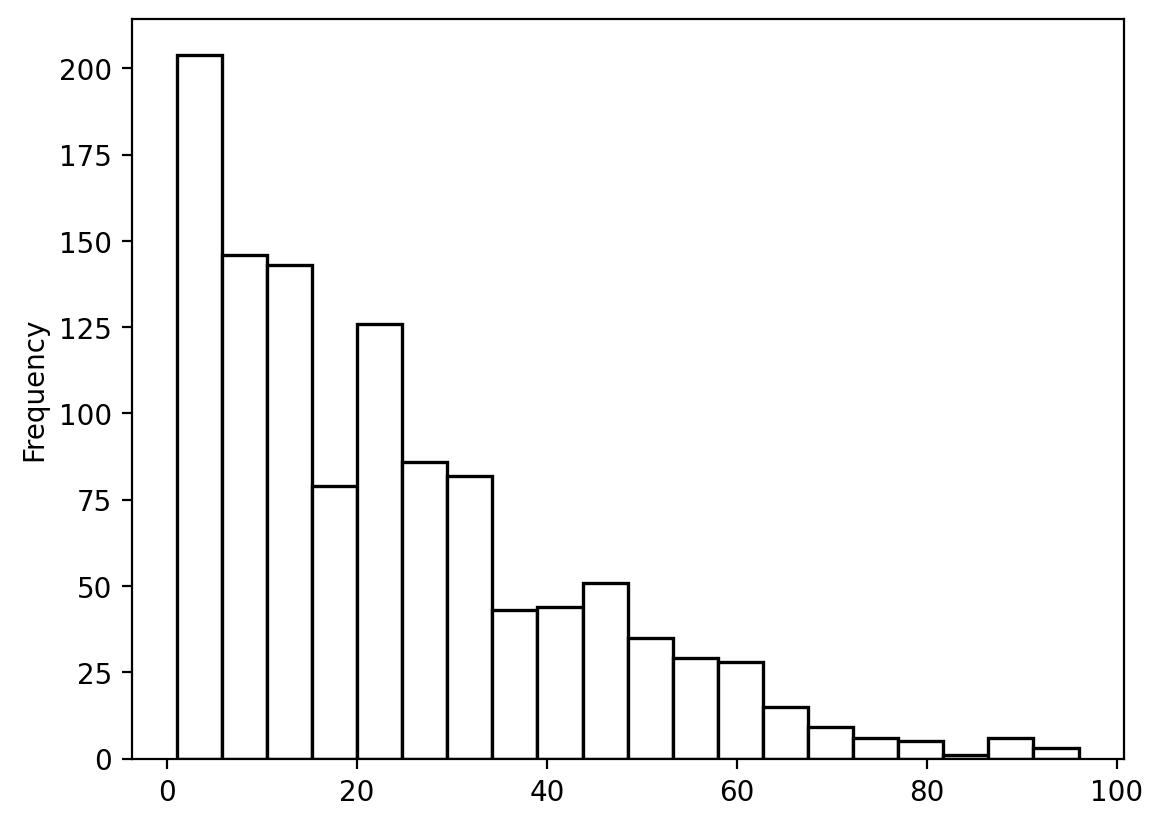

In [11]:
# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
plt.show()

In [12]:
data.describe()

Month           Day          Hour          Long     WindSpeed  \
count  21680.000000  21680.000000  21680.000000  21680.000000  21680.000000   
mean       8.670249     15.643681      9.119096    -63.332574     49.127629   
std        1.475817      8.863918      6.724253     20.804515     25.152288   
min        1.000000      1.000000      0.000000   -109.300000     10.000000   
25%        8.000000      8.000000      6.000000    -80.400000     30.000000   
50%        9.000000     16.000000     12.000000    -64.900000     40.000000   
75%       10.000000     23.000000     18.000000    -47.400000     60.000000   
max       12.000000     31.000000     23.000000     13.500000    165.000000   

           Pressure  
count  21680.000000  
mean     994.587315  
std       17.910808  
min      882.000000  
25%      988.000000  
50%     1001.000000  
75%     1007.000000  
max     1024.000000

In [13]:
# Since our keys are strings, we enumerate them to access them as integers
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))

# Now contains how many time instances of data (or rows) each hurricane contains
hurricane_amount = pd.DataFrame(y)

853


In [14]:
# Total amount of data tuples
total_data_count = len(data)
print(total_data_count)

21680


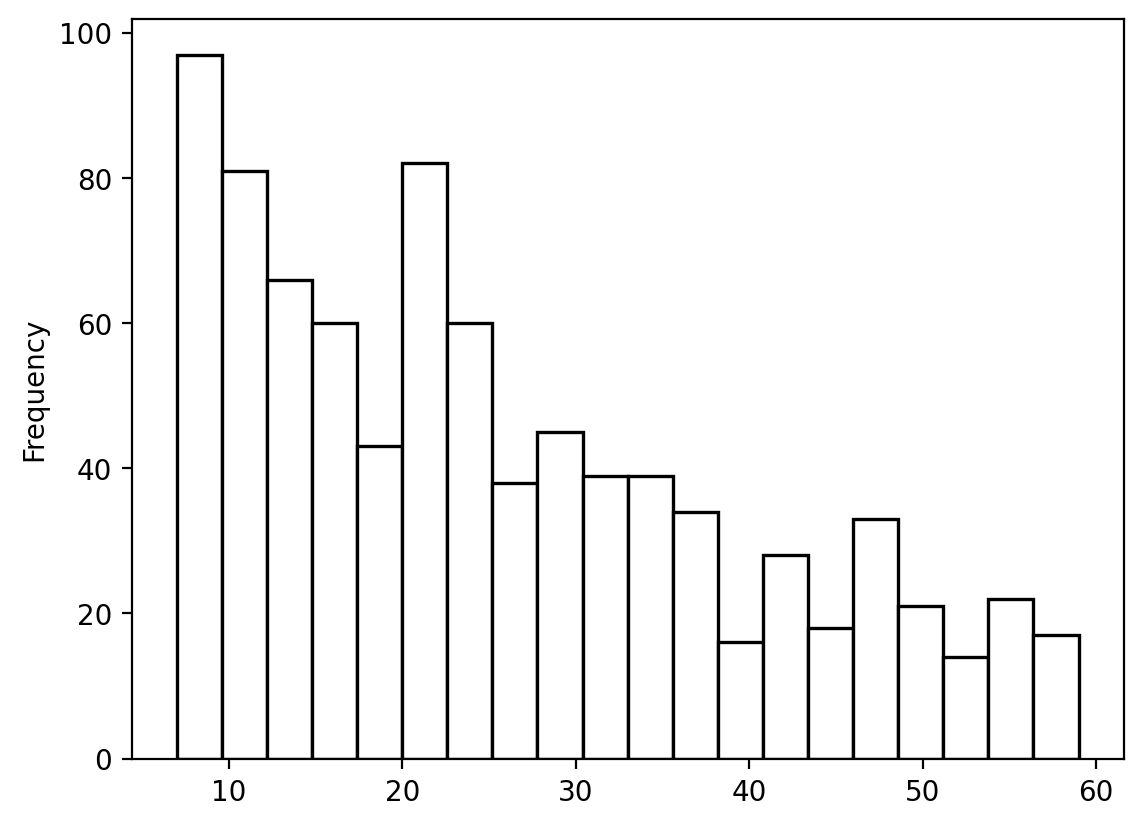

In [15]:
# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
# plt.savefig('frequency_graph', dpi=600)
plt.show()

In [16]:
data.to_csv('checkpoint-dataframem.csv') # Save the dataframe to csv for checkpoint

## Data Preprocessing

From the dataset, we have latitude and longitude information. It is more efficient for the model to learn using distance vectors, as these values are always positive, unlike latitude and longitude. To prepare our data, we will compute the travel angle and the distance between each point and include these as new columns in our DataFrame. Additionally, we will eliminate any outlier hurricanes to achieve a more normalized distribution for input into the model.

In [17]:
data = pd.read_csv('/content/checkpoint-dataframem.csv', index_col=0, header=0)

In [18]:
y = np.zeros(total_hurricane_count)
data['distance'] = np.zeros(total_data_count)
data['direction'] = np.zeros(total_data_count)

# For all hurricanes
for x in range(0, total_hurricane_count):
    t = pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)

    # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
    for p in zip(t['Lat'], t['Long']):

        if prev == (0,0):
            prev = p
            continue
        # Stores the distance into the DataFrame
        index_to_update = t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0]
        data.at[index_to_update, 'distance'] = vc(prev,p).miles

        dLon = p[1] - prev[1];
        temp = float(p[0]) # p[0] is a str?
        y_x = Math.sin(dLon) * Math.cos(temp);

        x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x))
        if (brng < 0):
            brng+= 360;

        # Stores the angle of travel into the DataFrame
        index_to_update = t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0]
        data.at[index_to_update, 'direction'] = brng
        dst += vc(prev,p).miles
        prev = p
    y[x] = dst

# Now contains the distance between all given latitude and longitude points
hurricane_distance = pd.DataFrame(y)

In [19]:
# Columns have been added
data.head()

Month  Day  Hour   Lat  Long  WindSpeed  Pressure            unique-key  \
0      5   16    18  28.0 -78.7       30.0      1008  ARTHUR-2020-AL012020   
1      5   17     0  28.9 -78.0       35.0      1006  ARTHUR-2020-AL012020   
2      5   17     6  29.6 -77.6       35.0      1004  ARTHUR-2020-AL012020   
3      5   17    12  30.3 -77.5       35.0      1003  ARTHUR-2020-AL012020   
4      5   17    18  31.0 -77.3       40.0      1003  ARTHUR-2020-AL012020   

    distance   direction  
0   0.000000    0.000000  
1  75.333355  289.382873  
2  54.043107  346.439371  
3  48.734494    3.018270  
4  49.804986   10.514512

In [20]:
print(hurricane_distance.shape)

(853, 1)


In [21]:
hurricane_distance.describe()

0
count   853.000000
mean   2178.532983
std    1391.951849
min      86.434363
25%    1070.844013
50%    1859.401520
75%    2971.291845
max    6572.689997

In [22]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in hurricane_distance.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_distance.loc[x][0], "miles -", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of distance traveled)
BERTHA-2014-AL032014 - 6572.689996921373 miles - 46.0
KATE-2003-AL162003 - 6392.865052499503 miles - 58.0
KATE-2003-16 - 6392.865052499503 miles - 58.0
BERTHA-1996-2 - 6391.7852319952735 miles - 51.0
RAFAEL-2012-AL172012 - 6351.748249370006 miles - 56.0
RAFAEL-2012-17 - 6351.748249370006 miles - 56.0


[[1.        0.7783713]
 [0.7783713 1.       ]]


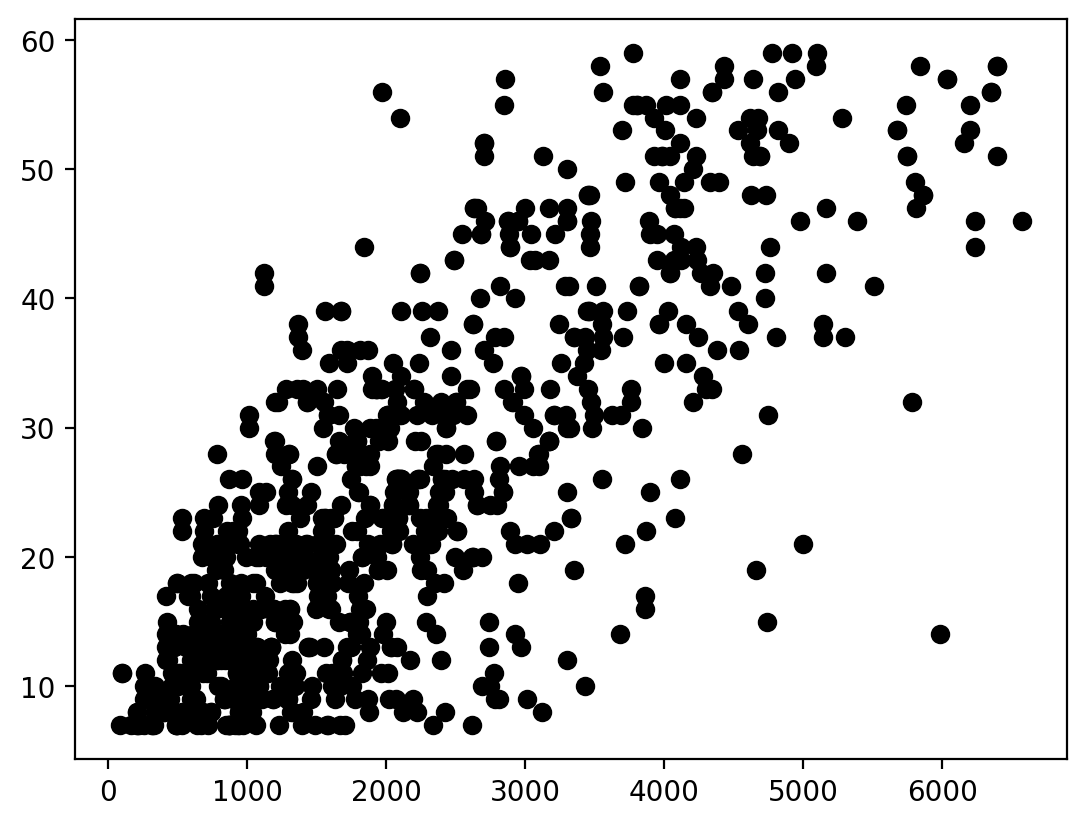

In [23]:
print( np.corrcoef(hurricane_distance[0], hurricane_amount[0]) )
# Plotted the amount of hurricane distance traveled vs the amount of data they contain.
corr = plt.scatter(hurricane_distance[0], hurricane_amount[0], color='black')
# plt.savefig('points_vs_distance', dpi=600)
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


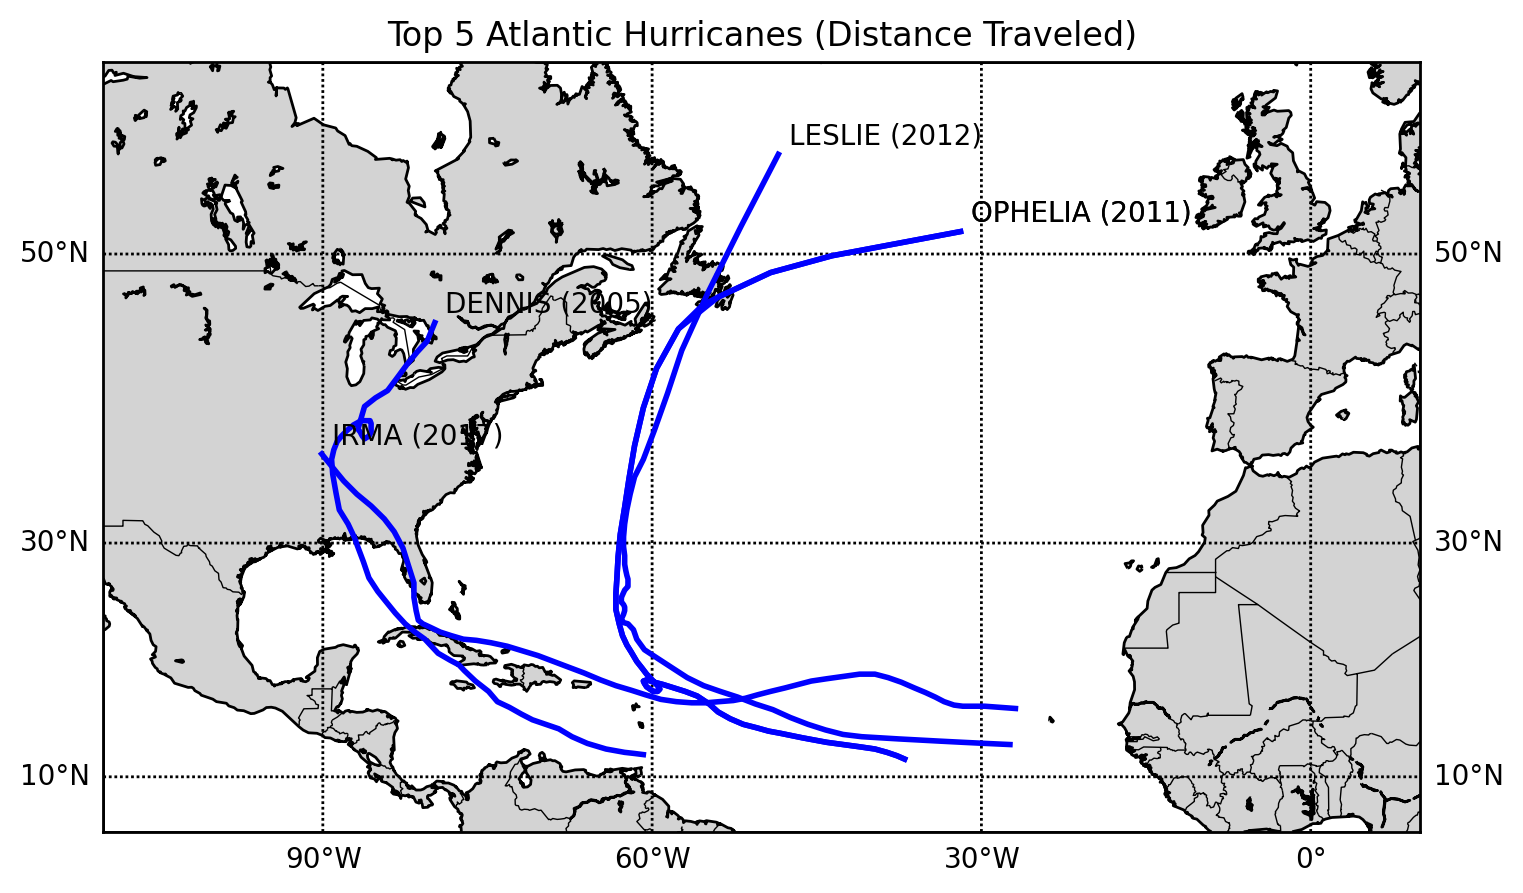

In [24]:
!pip install pyproj
!pip install basemap
import matplotlib.pyplot as plt
import numpy as np
# Import Basemap
from mpl_toolkits.basemap import Basemap


n = 5 # Number of hurricanes

# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nlargest(n,0).index:
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')

plt.title('Top 5 Atlantic Hurricanes (Distance Traveled)')
plt.show()

largest 5

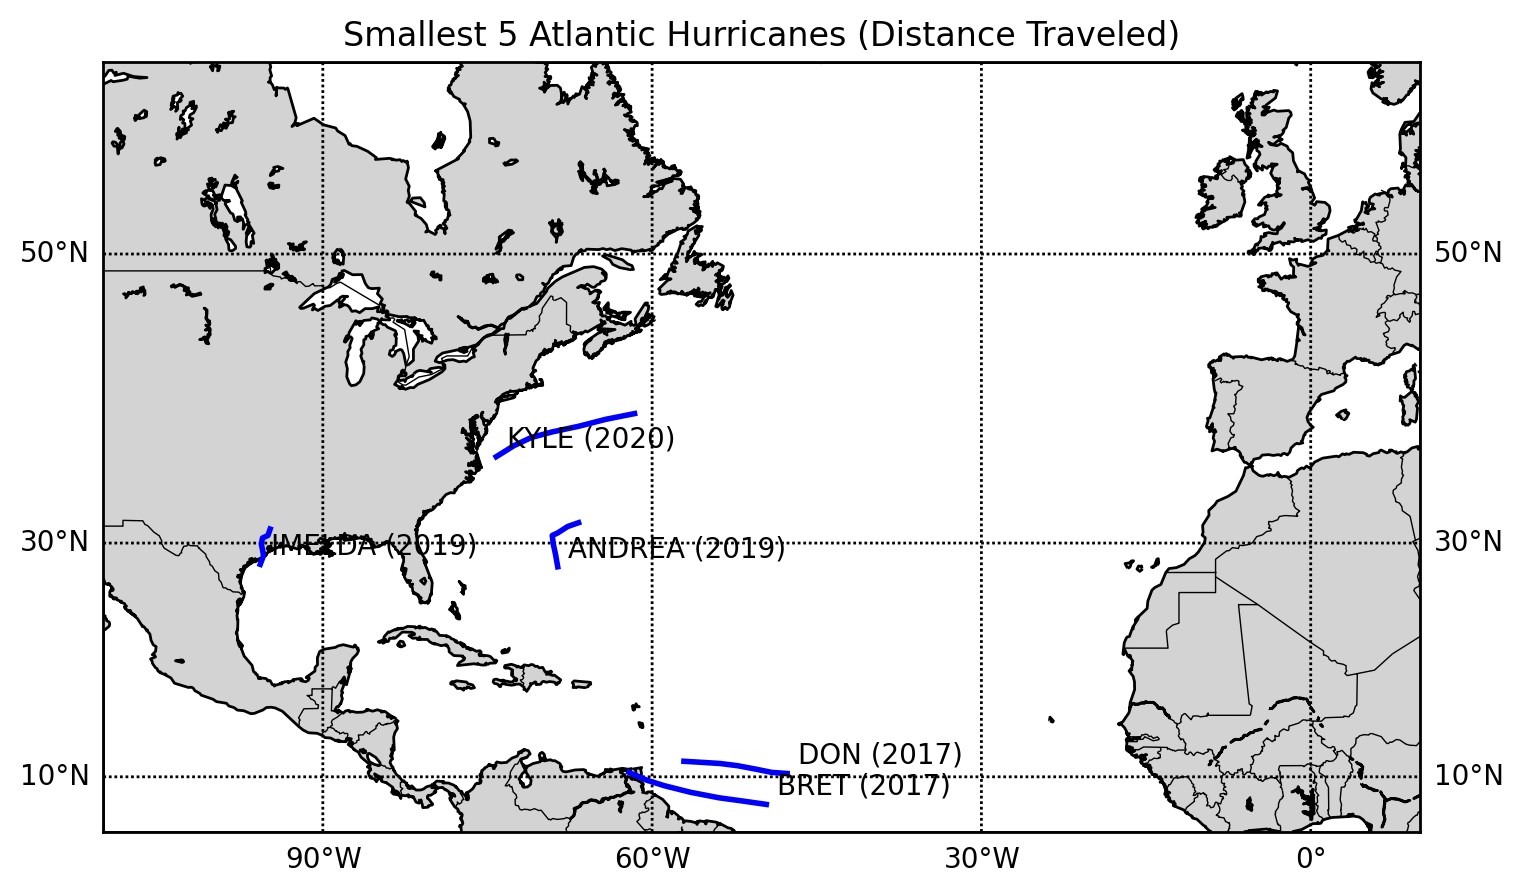

In [25]:
# Graph the trajectories of the shortest hurricanes (the ones that traveled the least)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nsmallest(n,0).index:
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')

plt.title('Smallest 5 Atlantic Hurricanes (Distance Traveled)')
plt.show()

smallest

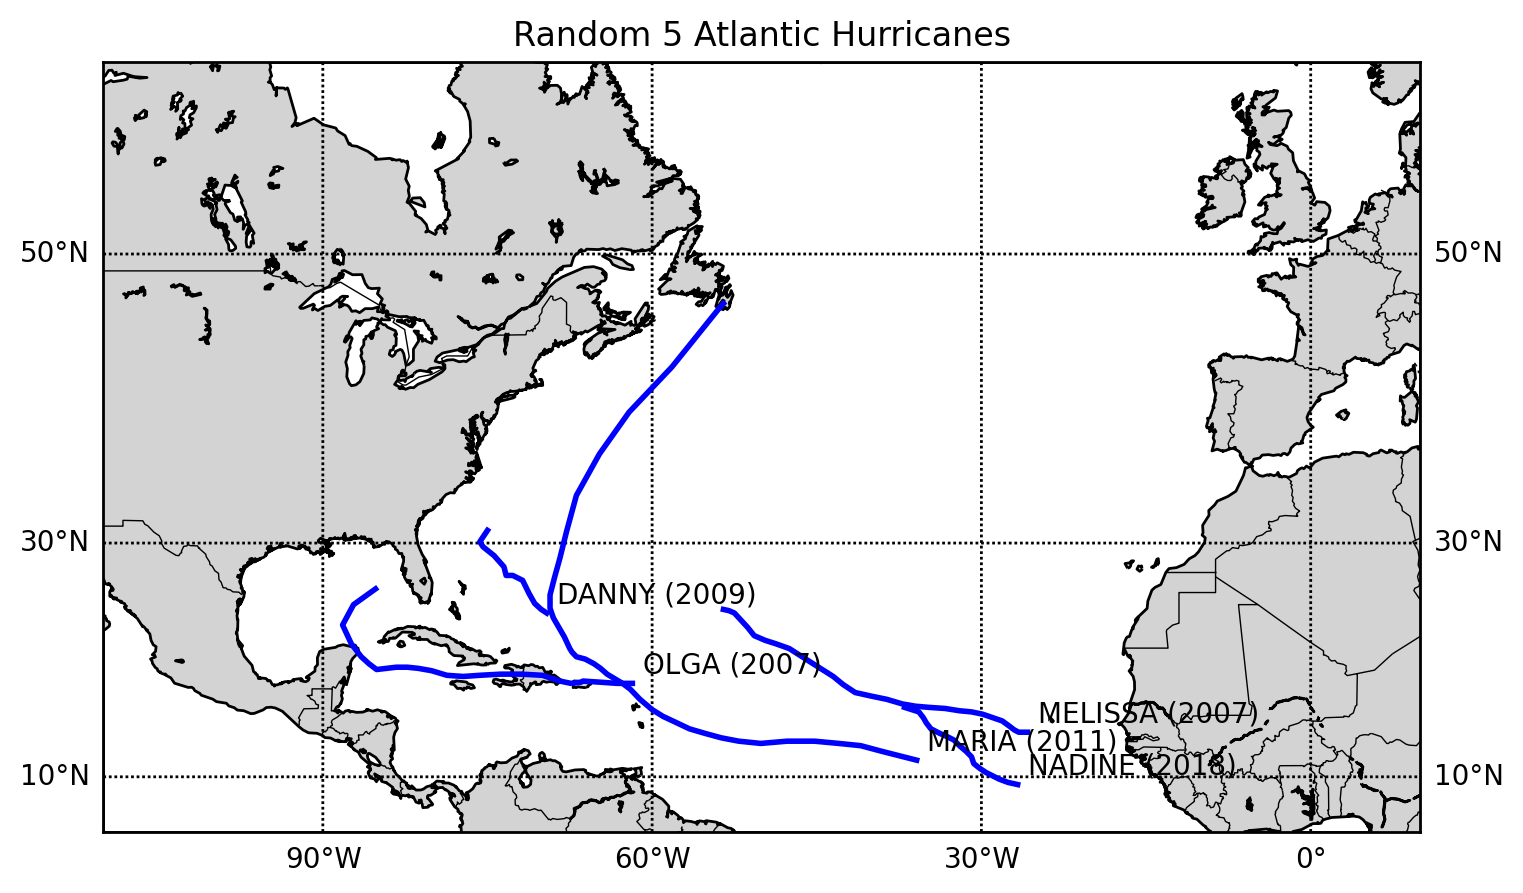

In [26]:
# Graph the trajectories of 3 random hurricanes
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in np.random.choice(total_hurricane_count, n):
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')

plt.title('Random 5 Atlantic Hurricanes')
plt.show()

In [27]:
data.head()

Month  Day  Hour   Lat  Long  WindSpeed  Pressure            unique-key  \
0      5   16    18  28.0 -78.7       30.0      1008  ARTHUR-2020-AL012020   
1      5   17     0  28.9 -78.0       35.0      1006  ARTHUR-2020-AL012020   
2      5   17     6  29.6 -77.6       35.0      1004  ARTHUR-2020-AL012020   
3      5   17    12  30.3 -77.5       35.0      1003  ARTHUR-2020-AL012020   
4      5   17    18  31.0 -77.3       40.0      1003  ARTHUR-2020-AL012020   

    distance   direction  
0   0.000000    0.000000  
1  75.333355  289.382873  
2  54.043107  346.439371  
3  48.734494    3.018270  
4  49.804986   10.514512

In [28]:
import scipy
dist = data[data['distance'] > 0]['distance']
scipy.stats.anderson(dist, dist='norm')

AndersonResult(statistic=1083.1623142232784, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=89.58916104744672, scale=74.22303666981283)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [29]:
import sklearn

dist_norm = normalized = (dist-min(dist))/(max(dist)-min(dist))
scipy.stats.anderson(dist_norm, dist='norm')

AndersonResult(statistic=1083.162314223282, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.04782072889900441, scale=0.042136973287008626)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

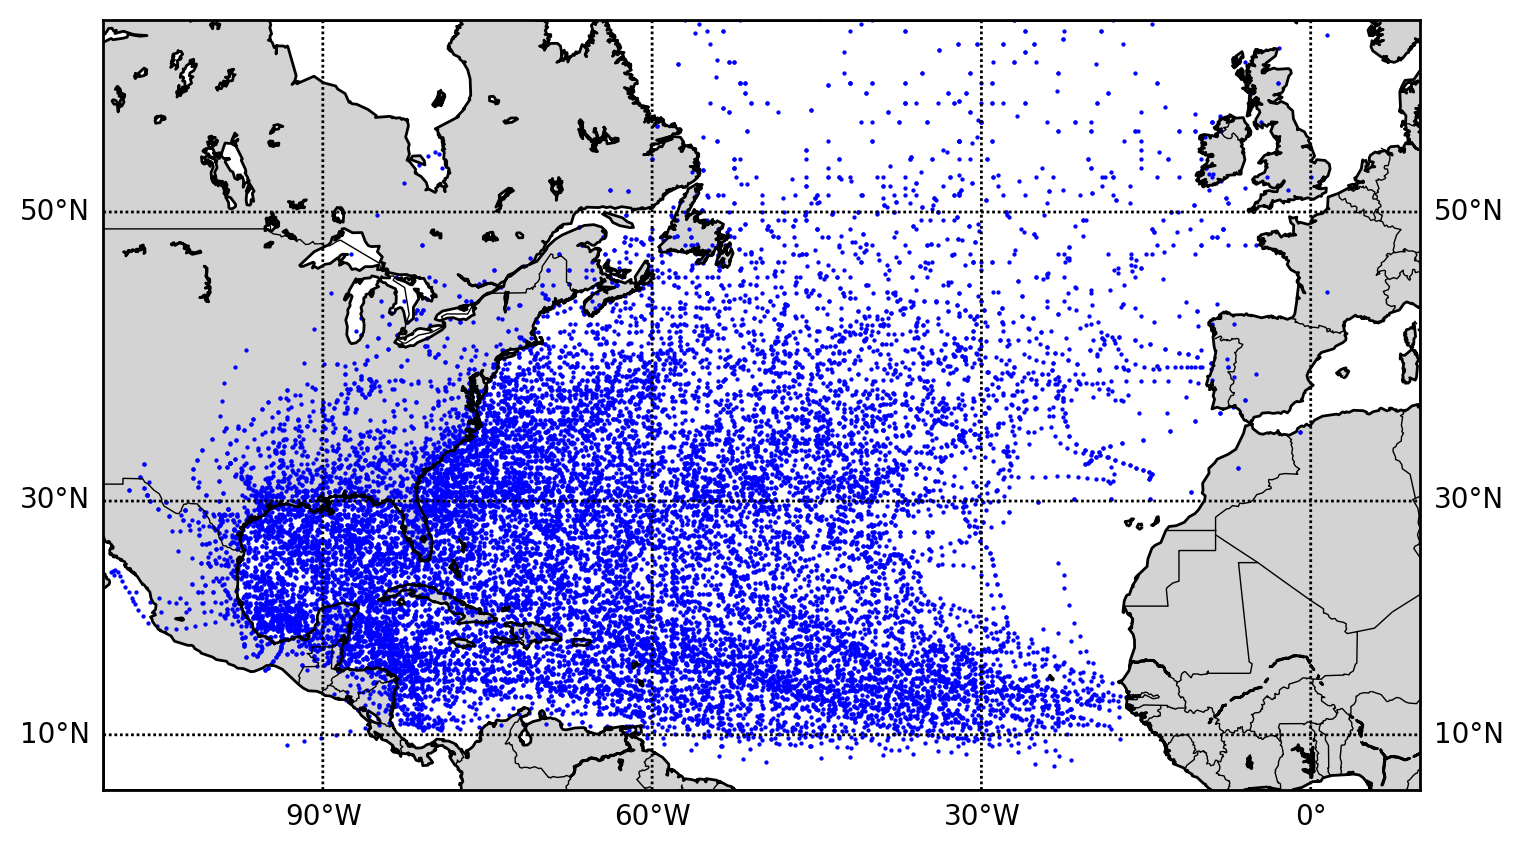

In [30]:
# Graph all points
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

lat = data['Lat'].values
long = data['Long'].values
xpt, ypt = m(long, lat)
m.scatter(xpt, ypt, .3, color='blue')

plt.show()

In [31]:
print(len(xpt))

21680


In [32]:
# Assigning each point to a specific location in the grid.
# For example, we will learn how a hurricane in quadrant 2 with move.
data['gridID'] = np.zeros(total_data_count)

In [33]:
# These variable are hyperparameters
lat_min = 7.2
long_min = -109.3
lat_interval = round(66 - 7.2)
long_interval = round(13.5 + 109.3)

data['gridID'] = np.floor(data['Lat'] - 7.200)* long_interval  + np.floor(data['Long'] + 109.3)
data['gridID'] = round(data['gridID'])

In [34]:
data.describe()

Month           Day          Hour           Lat          Long  \
count  21680.000000  21680.000000  21680.000000  21680.000000  21680.000000   
mean       8.670249     15.643681      9.119096     26.882685    -63.332574   
std        1.475817      8.863918      6.724253     10.089981     20.804515   
min        1.000000      1.000000      0.000000      7.200000   -109.300000   
25%        8.000000      8.000000      6.000000     18.500000    -80.400000   
50%        9.000000     16.000000     12.000000     26.600000    -64.900000   
75%       10.000000     23.000000     18.000000     33.300000    -47.400000   
max       12.000000     31.000000     23.000000     69.000000     13.500000   

          WindSpeed      Pressure      distance     direction        gridID  
count  21680.000000  21680.000000  21680.000000  21680.000000  21680.000000  
mean      49.127629    994.587315     85.634510    171.156973   2408.084041  
std       25.152288     17.910808     74.863455    112.490070   1245.264987  
min       10.000000    882.000000      0.000000      0.000000     55.000000  
25%       30.000000    988.000000     44.006926     70.458621   1384.000000  
50%       40.000000   1001.000000     71.920245    176.776402   2366.000000  
75%       60.000000   1007.000000    108.321455    264.468643   3225.000000  
max      165.000000   1024.000000   1766.824886    359.938162   7597.000000

In [35]:
data.to_csv('checkpoint-dataframe1.csv') # Save the dataframe to csv for checkpoint

## Build the Model

In [36]:
data = pd.read_csv('/content/checkpoint-dataframe1.csv', index_col=0)

In [37]:
data.head() # Check loaded data

Month  Day  Hour   Lat  Long  WindSpeed  Pressure            unique-key  \
0      5   16    18  28.0 -78.7       30.0      1008  ARTHUR-2020-AL012020   
1      5   17     0  28.9 -78.0       35.0      1006  ARTHUR-2020-AL012020   
2      5   17     6  29.6 -77.6       35.0      1004  ARTHUR-2020-AL012020   
3      5   17    12  30.3 -77.5       35.0      1003  ARTHUR-2020-AL012020   
4      5   17    18  31.0 -77.3       40.0      1003  ARTHUR-2020-AL012020   

    distance   direction  gridID  
0   0.000000    0.000000  2490.0  
1  75.333355  289.382873  2614.0  
2  54.043107  346.439371  2737.0  
3  48.734494    3.018270  2860.0  
4  49.804986   10.514512  2861.0

In [38]:
names = data['unique-key'].unique()
data.drop(['Month', 'Day', 'Hour', 'Lat', 'Long'], axis = 1, inplace = True)
data.head()

WindSpeed  Pressure            unique-key   distance   direction  gridID
0       30.0      1008  ARTHUR-2020-AL012020   0.000000    0.000000  2490.0
1       35.0      1006  ARTHUR-2020-AL012020  75.333355  289.382873  2614.0
2       35.0      1004  ARTHUR-2020-AL012020  54.043107  346.439371  2737.0
3       35.0      1003  ARTHUR-2020-AL012020  48.734494    3.018270  2860.0
4       40.0      1003  ARTHUR-2020-AL012020  49.804986   10.514512  2861.0

In [39]:
np.array(data)

array([[30.0, 1008, 'ARTHUR-2020-AL012020', 0.0, 0.0, 2490.0],
       [35.0, 1006, 'ARTHUR-2020-AL012020', 75.3333553297853,
        289.3828729721004, 2614.0],
       [35.0, 1004, 'ARTHUR-2020-AL012020', 54.04310722318213,
        346.4393712820733, 2737.0],
       ...,
       [70.0, 975, 'NOTNAMED-1929-2', 479.9202138698258,
        32.902723473217954, 2852.0],
       [60.0, 975, 'NOTNAMED-1929-2', 22.61060368758486,
        19.576091043963004, 2852.0],
       [55.0, 986, 'NOTNAMED-1929-2', 82.46837457733908,
        58.54528785490512, 2854.0]], dtype=object)

In [40]:
np.unique(data['unique-key'])

array(['ABBY-1968-1', 'AGNES-1972-2', 'ALBERTO-1982-1', 'ALBERTO-1988-1',
       'ALBERTO-1994-1', 'ALBERTO-2006-1', 'ALBERTO-2006-AL012006',
       'ALBERTO-2012-1', 'ALBERTO-2012-AL012012', 'ALBERTO-2018-AL012018',
       'ALEX-1998-1', 'ALEX-2004-1', 'ALEX-2004-AL012004', 'ALEX-2010-1',
       'ALEX-2010-AL012010', 'ALEX-2016-AL012016', 'ALICE-1973-4',
       'ALICIA-1983-3', 'ALLEN-1980-4', 'ALLISON-1989-2',
       'ALLISON-1995-1', 'ALLISON-2001-1', 'ALLISON-2001-AL012001',
       'ALMA-1962-1', 'ALMA-1966-1', 'ALMA-1970-1', 'ALPHA-1972-1',
       'ALPHA-2005-26', 'ALPHA-2005-AL262005', 'ALPHA-2020-AL242020',
       'AMY-1975-2', 'ANA-1979-2', 'ANA-1985-1', 'ANA-1991-1',
       'ANA-1997-2', 'ANA-2003-1', 'ANA-2003-AL012003', 'ANA-2009-2',
       'ANA-2009-AL022009', 'ANA-2015-AL012015', 'ANDREA-2007-1',
       'ANDREA-2007-AL012007', 'ANDREA-2013-AL012013',
       'ANDREA-2019-AL012019', 'ANDREW-1986-1', 'ANDREW-1992-4',
       'ANITA-1977-5', 'ANNA-1961-1', 'ANNA-1969-6', 'ANNA-

In [41]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']]]

In [42]:
data_pad[0:3]

[       WindSpeed  Pressure    distance   direction  gridID
 31570       30.0      1005    0.000000    0.000000  1376.0
 31573       40.0      1002  190.999054  230.915394  1746.0
 31574       45.0       997   73.125660  248.497817  1870.0
 31575       60.0       999   71.686942  348.773839  1993.0
 31576       65.0       999   85.050130   14.434896  2116.0
 31578       65.0       994   45.526444   17.180714  2117.0
 31579       60.0       993   54.424009   18.917150  2240.0
 31580       55.0       992   90.717511  350.544696  2364.0
 31583       50.0       994  110.827466  292.193468  2488.0
 31585       50.0       965   47.486532  321.421596  2489.0
 31586       50.0       997   18.441810  348.103154  2489.0
 31590       50.0       999  201.090838  223.305339  2856.0,
        WindSpeed  Pressure    distance   direction  gridID
 25727       30.0      1001    0.000000    0.000000  1498.0
 25729       40.0       998   51.941213  147.232643  1499.0
 25737       65.0       986  265.356052

In [43]:
len(data)
len(data_pad)
len_vals = []
for x in range(len(data_pad)):
    len_vals += [len(data_pad[x])]
print(max(len_vals))

59


In [44]:
import keras
padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=60, dtype='int32', padding='post', truncating='pre', value=0.0)

In [45]:
max(data['gridID']) # Total grid spots

7597.0

In [46]:
# Normalize the values to predict them more easily in our model
scalers = {}
gridScalers = {}
for name in names:
    scalers[name] = MinMaxScaler(feature_range=(0, 1))
#     gridScalers[name] = MinMaxScaler(feature_range=(0, 1))
#     gridScalers[name].fit_transform((data[data['unique-key'] == name])['gridID'].reshape(-1,1))
    hurricane = data[data['unique-key'] == name]
    hurricane.drop('unique-key', axis = 1, inplace= True)

    hurricane = pd.DataFrame(scalers[name].fit_transform(hurricane), columns=['WindSpeed',
                                                                              'Pressure',
                                                                              'distance',
                                                                              'direction',
                                                                              'gridID'])
    data.loc[data['unique-key'] == name, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']] = hurricane.values

<ipython-input-46-4ae41845b6dc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hurricane.drop('unique-key', axis = 1, inplace= True)
<ipython-input-46-4ae41845b6dc>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         0.89473684 0.78947368 0.73684211 0.73684211 0.73684211
 0.68421053 0.57894737 0.21052632 0.10526316 0.05263158 0.
 0.10526316 0.21052632 0.42105263 0.68421053 0.89473684 1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['unique-key'] == name, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']] = hurricane.values
<ipython-input-46-4ae41845b6dc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [47]:
data.head()

WindSpeed  Pressure            unique-key  distance  direction    gridID
0        0.0  1.000000  ARTHUR-2020-AL012020  0.000000   0.000000  0.000000
1        0.2  0.894737  ARTHUR-2020-AL012020  0.711468   0.831068  0.110813
2        0.2  0.789474  ARTHUR-2020-AL012020  0.510398   0.994926  0.220733
3        0.2  0.736842  ARTHUR-2020-AL012020  0.460262   0.008668  0.330652
4        0.4  0.736842  ARTHUR-2020-AL012020  0.470372   0.030196  0.331546

In [48]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']]]

In [49]:
data_pad[1]

WindSpeed  Pressure  distance  direction    gridID
25727   0.000000  1.000000  0.000000   0.000000  0.000000
25729   0.222222  0.875000  0.160248   0.410819  0.000385
25737   0.777778  0.375000  0.818671   0.037548  0.189908
25738   0.777778  0.250000  0.214049   0.531265  0.237288
25739   1.000000  0.208333  0.255799   0.502249  0.284669
25740   1.000000  0.041667  0.255799   0.502249  0.379430
25741   1.000000  0.041667  0.277115   0.000000  0.426810
25742   0.777778  0.250000  0.235221   1.000000  0.474191
25744   0.000000  0.541667  0.417785   0.232419  0.569337
25746   0.000000  0.625000  0.468836   0.031535  0.617488
25747   0.000000  0.625000  0.234209   0.929757  0.665254
25749   0.000000  0.541667  0.514511   0.608734  0.713790
25750   0.222222  0.458333  0.298548   0.801251  0.761556
25753   0.666667  0.000000  1.000000   0.720076  0.905624
25754   0.555556  0.125000  0.429201   0.077594  1.000000

In [50]:
padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=60, dtype='float', padding='post', truncating='pre', value=0.0)

In [51]:
print(len(padded_data[0]))
print(len(padded_data))

60
853


In [52]:
temp_flat = padded_data.reshape(60*len(padded_data),5)
print(temp_flat[0:200])
print(temp_flat.shape)

[[0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.85714286e-01 9.25000000e-01 9.49814800e-01 6.58733098e-01
  2.50000000e-01]
 [4.28571429e-01 8.00000000e-01 3.63644912e-01 7.08890533e-01
  3.33783784e-01]
 [8.57142857e-01 8.50000000e-01 3.56490346e-01 9.94948268e-01
  4.16891892e-01]
 [1.00000000e+00 8.50000000e-01 4.22943834e-01 4.11784754e-02
  5.00000000e-01]
 [1.00000000e+00 7.25000000e-01 2.26397407e-01 4.90114784e-02
  5.00675676e-01]
 [8.57142857e-01 7.00000000e-01 2.70643902e-01 5.39650168e-02
  5.83783784e-01]
 [7.14285714e-01 6.75000000e-01 4.51127025e-01 1.00000000e+00
  6.67567568e-01]
 [5.71428571e-01 7.25000000e-01 5.51131357e-01 8.33541260e-01
  7.51351351e-01]
 [5.71428571e-01 0.00000000e+00 2.36144682e-01 9.16920436e-01
  7.52027027e-01]
 [5.71428571e-01 8.00000000e-01 9.17088519e-02 9.93035004e-01
  7.52027027e-01]
 [5.71428571e-01 8.50000000e-01 1.00000000e+00 6.37023870e-01
  1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.000000

In [53]:
def load_data(stock, seq_len, amount_of_features):
#     amount_of_features = len(stock.columns)
#     data = stock.as_matrix()
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []

    for index in range(len(stock) - sequence_length):
        seq = stock[index: index + sequence_length]
        result.append(seq)

    result = np.array(result)
    row = len(result) * 0.85 # Amount of data to train on
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return [x_train, y_train, x_test, y_test]

### Train the Model

In [54]:
seq_len = 12 # Another hyperparameter- length of hurricane?
feature_count = 5
X_train, y_train, X_test, y_test = load_data(temp_flat[::-1], seq_len, feature_count)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (43491, 12, 5)
y_train (43491,)
X_test (7676, 12, 5)
y_test (7676,)


In [55]:
def build_model(layers):
    model = Sequential()

    # Correct the input_shape to (seq_len, feature_count)
    model.add(LSTM(units=layers[1], return_sequences=True, input_shape=(seq_len, layers[0])))
    model.add(Dropout(0.1))

    for x in range(0,2): #Adjusted loop for subsequent LSTM layers
        model.add(LSTM(units=layers[1], return_sequences=True))
        model.add(Dropout(0.1))

    model.add(LSTM(units=layers[2], return_sequences=False))
    model.add(Dropout(0.1))

    model.add(Dense(units=layers[2]))
    model.add(Activation("tanh"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [56]:
model = build_model([feature_count, seq_len, 1])

Compilation Time :  0.010083436965942383


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
model.fit(X_train, y_train, batch_size=512, epochs=200, validation_split=0.1, verbose=1)

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5881 - loss: 0.0979 - val_accuracy: 0.6432 - val_loss: 0.0684
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5878 - loss: 0.0715 - val_accuracy: 0.6432 - val_loss: 0.0551
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5858 - loss: 0.0595 - val_accuracy: 0.6386 - val_loss: 0.0464
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5892 - loss: 0.0491 - val_accuracy: 0.6402 - val_loss: 0.0371
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5915 - loss: 0.0426 - val_accuracy: 0.6428 - val_loss: 0.0300
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5927 - loss: 0.0358 - val_accuracy: 0.6441 - val_loss: 0.0246
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5984 - loss: 0.0319 - val_accuracy: 0.6471 - val_loss: 0.0227
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5918 - loss: 0.0298 - val_accuracy: 0.

In [58]:
#SAVING MODEL

# Serialize model to JSON
model_json = model.to_json()
with open("/content/model_sheils.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5/content/checkpoint-dataframe1.csv
# Changed filename to include .weights.h5
model.save_weights("/content/model_sheils.weights.h5")
print("Saved Model to Disk")

Saved Model to Disk


## Predicting Hurricane Trajectory

In [59]:
# Load json and create model
json_file = open('/content/model_sheils.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("/content/model_sheils.weights.h5")
print("Loaded Model from Disk")
model = loaded_model

# Evaluate loaded model on test data
#loaded_model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded Model from Disk


In [60]:
pred = model.predict(X_test)

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [61]:
len(pred)

7676

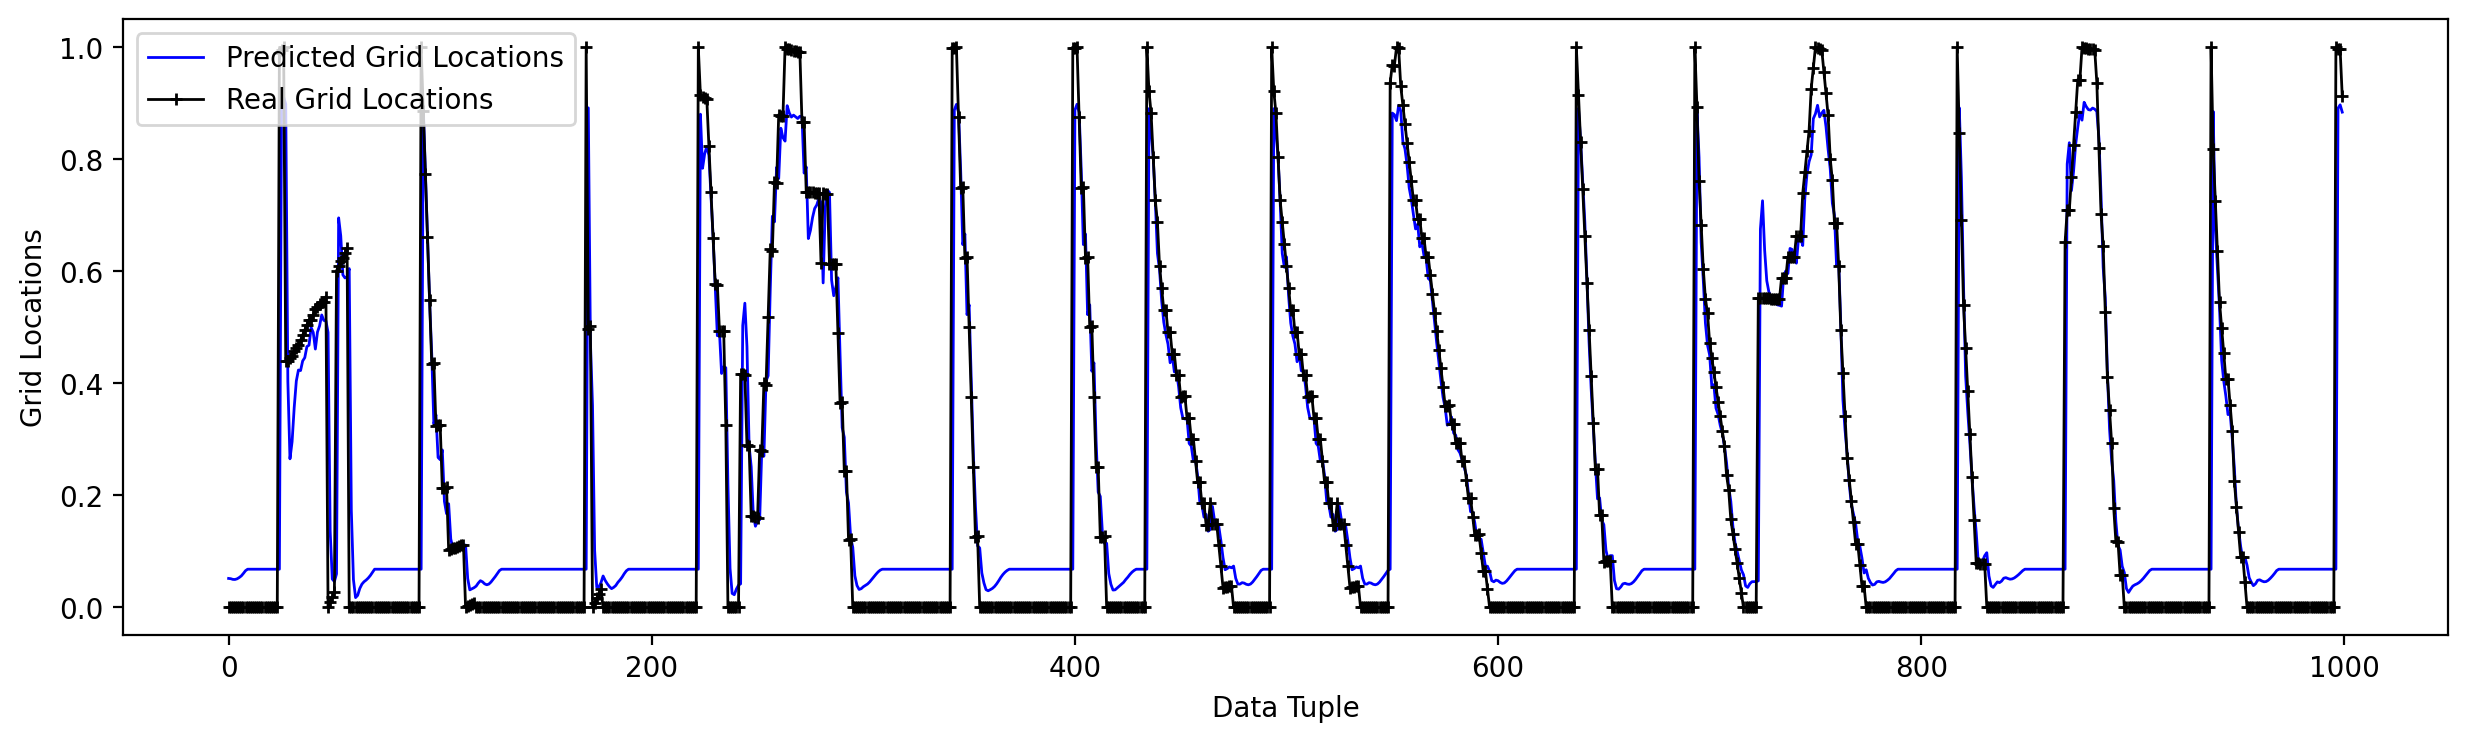

In [62]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred[:1000],
         linewidth=1,
         color='blue',
         label='Predicted Grid Locations')
plt.plot(y_test[:1000],
         linewidth=1,
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
# plt.savefig('denormalized_predictions')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')

plt.legend(loc='upper left')
# plt.savefig('grid_accuracy.png')
plt.show()

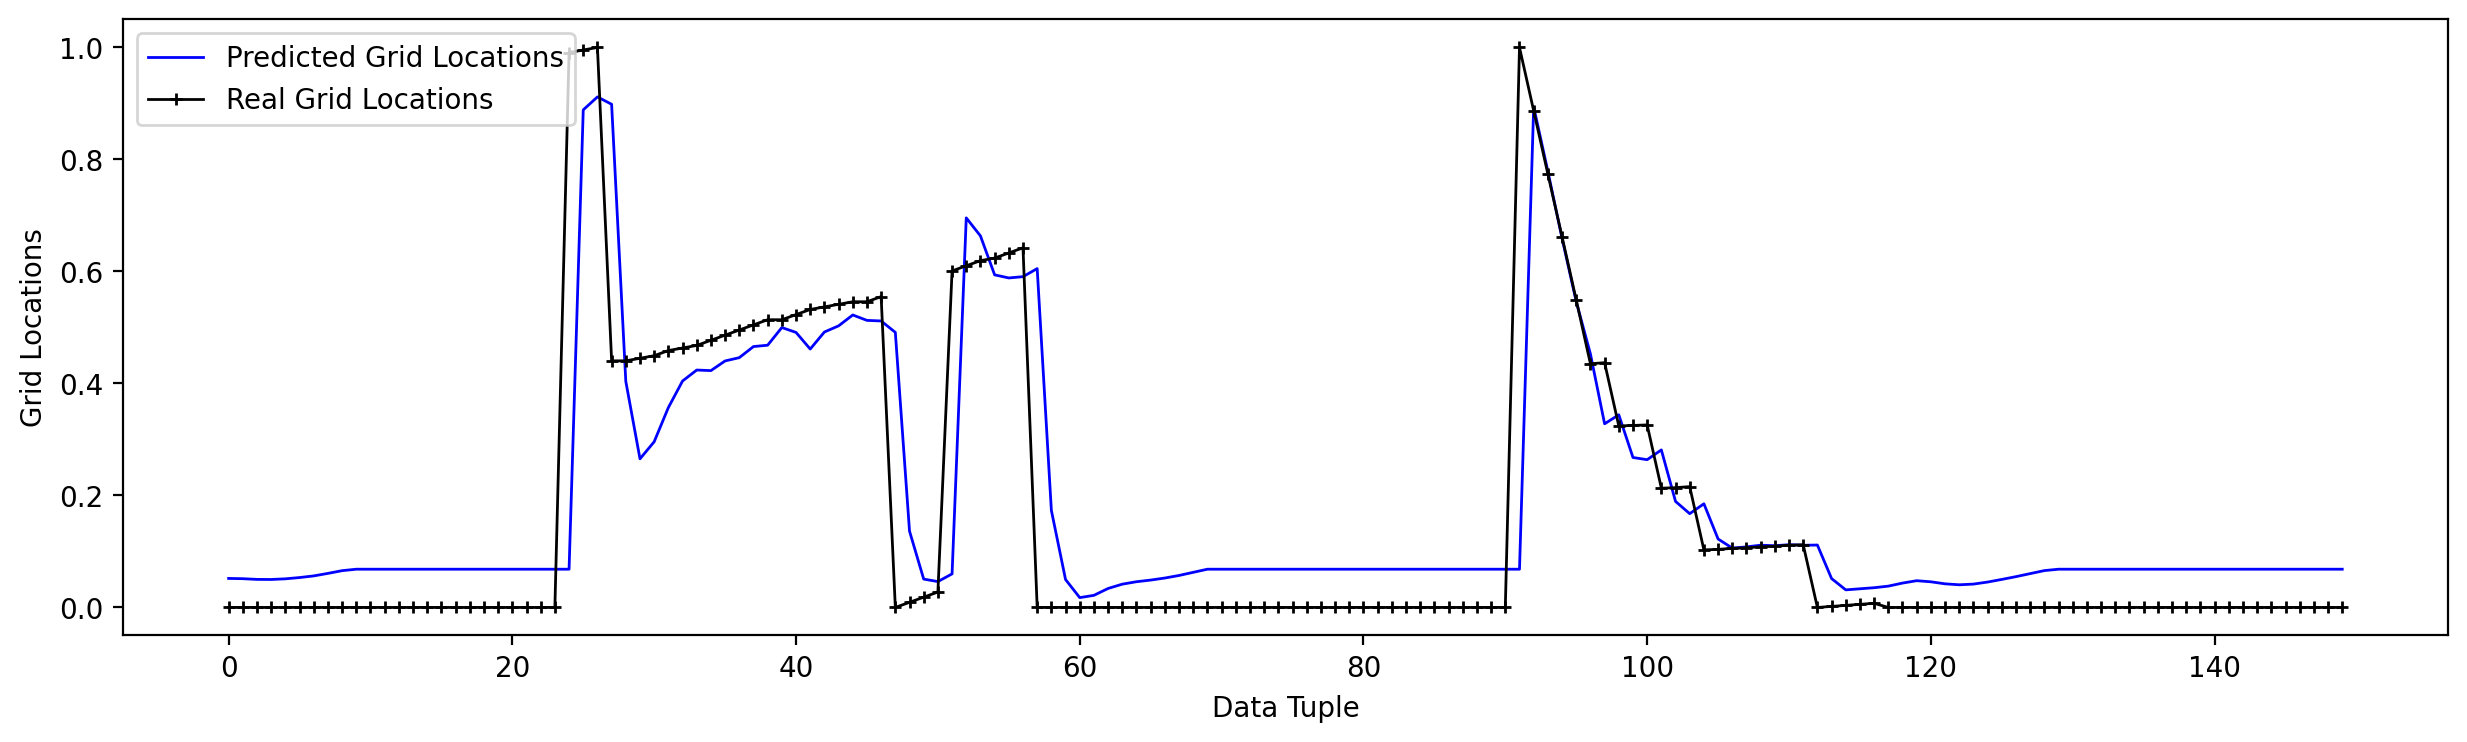

In [63]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred[:150],
         linewidth=1,
         color='blue',
         label='Predicted Grid Locations')
plt.plot(y_test[:150],
         linewidth=1,
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
# plt.savefig('denormalized_predictions')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')

plt.legend(loc='upper left')
# plt.savefig('grid_accuracy.png')
plt.show()

In [64]:
pred[0:60].flatten()

array([0.0518121 , 0.05133918, 0.05009213, 0.04993714, 0.05109141,
       0.05338728, 0.05631976, 0.06081541, 0.06567208, 0.06828361,
       0.06828361, 0.06828361, 0.06828361, 0.06828361, 0.06828361,
       0.06828361, 0.06828361, 0.06828361, 0.06828361, 0.06828361,
       0.06828361, 0.06828361, 0.06828361, 0.06828361, 0.06828361,
       0.8885192 , 0.9116572 , 0.89853036, 0.40365613, 0.26537207,
       0.2958874 , 0.3569177 , 0.4043655 , 0.42395064, 0.42292702,
       0.44019642, 0.4460607 , 0.46587023, 0.46828353, 0.49983722,
       0.49110284, 0.4614233 , 0.4918509 , 0.50282645, 0.52226466,
       0.5126079 , 0.51157075, 0.4911774 , 0.1362399 , 0.05062632,
       0.04618404, 0.05994115, 0.6956807 , 0.6634603 , 0.59391373,
       0.5883955 , 0.59067076, 0.60506755, 0.17326827, 0.04980503],
      dtype=float32)

In [65]:
flat_pred = pred.flatten()

In [66]:
y_test[0:80]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99082569,
       0.99541284, 1.        , 0.44036697, 0.44036697, 0.44495413,
       0.44954128, 0.4587156 , 0.46330275, 0.46788991, 0.47706422,
       0.48623853, 0.49541284, 0.50458716, 0.51376147, 0.51376147,
       0.52293578, 0.53211009, 0.53669725, 0.5412844 , 0.54587156,
       0.54587156, 0.55504587, 0.        , 0.00917431, 0.01834862,
       0.02752294, 0.60091743, 0.61009174, 0.61926606, 0.62385321,
       0.63302752, 0.64220183, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [67]:
hurr_real = []
hurr_pred = []
temp_real = []
temp_pred = []
for x in range(len(y_test)):
#     print(y_test[x])
    if not y_test[x] == 0:
        temp_real += [y_test[x]]
#         print(len(temp_real))
        temp_pred += [flat_pred[x]]
#         print(len(temp_pred))
    else:
        hurr_real += [temp_real]
#             print(hurr_real)
        hurr_pred += [temp_pred]
#             print(hurr_pred)
#             print(' ')
#             plt.plot(hurr_real, hurr_pred)
        temp_real = []
        temp_pred = []


In [68]:
print(len(hurr_real))
print(len(hurr_pred))

lol_real = [x for x in hurr_real if bool(x)]
print(len(lol_real))
lol_pred = [x for x in hurr_pred if bool(x)]
print(len(lol_pred))

4746
4746
182
182


In [69]:
model.summary()
model.get_config()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 12)              │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 12, 12)              │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 12, 12)              │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,646 (25.96 KB)

 Trainable params: 3,322 (12.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,324 (12.99 KB)

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 12, 5),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'zero_output_for_mask': False,
    'units': 12,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {

##[Hurricane IDALIA 2023]

In [70]:
data = pd.read_csv('/content/test_idalia_2023.csv', index_col=0)

In [71]:
names = data['unique-key'].unique()
data.drop(['Month', 'Day', 'Hour', 'Lat', 'Long'], axis = 1, inplace = True)

In [72]:
np.array(data)

array([[25, 1006, '             IDALIA-2023-AL102023', 0.0, 0.0, 1622.0],
       [25, 1006, '             IDALIA-2023-AL102023',
        35.143348588635945, 6.9662524992495465, 1745.0],
       [30, 1004, '             IDALIA-2023-AL102023', 18.89285689827645,
        11.37265598706674, 1621.0],
       [30, 1002, '             IDALIA-2023-AL102023', 48.84772713028992,
        3.843447476523806, 1621.0],
       [35, 999, '             IDALIA-2023-AL102023', 52.62856830240241,
        155.19160467298047, 1499.0],
       [40, 996, '             IDALIA-2023-AL102023', 32.48385011839352,
        164.28388656419088, 1499.0],
       [45, 992, '             IDALIA-2023-AL102023', 26.89783464333804,
        166.91595533410816, 1499.0],
       [55, 989, '             IDALIA-2023-AL102023', 14.719975999428678,
        174.27984760695134, 1500.0],
       [55, 989, '             IDALIA-2023-AL102023', 48.36539522124196,
        180.0, 1623.0],
       [60, 986, '             IDALIA-2023-AL102023', 41

In [73]:
np.unique(data['unique-key'])

array(['             IDALIA-2023-AL102023'], dtype=object)

In [74]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']]]

In [75]:
len(data)
len(data_pad)
len_vals = []
for x in range(len(data_pad)):
    len_vals += [len(data_pad[x])]

In [76]:
import keras
padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=60, dtype='int32', padding='post', truncating='pre', value=0.0)

In [77]:
# Normalize the values to predict them more easily in our model
scalers = {}
gridScalers = {}
for name in names:
    scalers[name] = MinMaxScaler(feature_range=(0, 1))
#     gridScalers[name] = MinMaxScaler(feature_range=(0, 1))
#     gridScalers[name].fit_transform((data[data['unique-key'] == name])['gridID'].reshape(-1,1))
    hurricane = data[data['unique-key'] == name]
    hurricane.drop('unique-key', axis = 1, inplace= True)

    hurricane = pd.DataFrame(scalers[name].fit_transform(hurricane), columns=['WindSpeed',
                                                                              'Pressure',
                                                                              'distance',
                                                                              'direction',
                                                                              'gridID'])
    data.loc[data['unique-key'] == name, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']] = hurricane.values

<ipython-input-77-4ae41845b6dc>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.     0.     0.0625 0.0625 0.125  0.1875 0.25   0.375  0.375  0.4375
 0.4375 0.5    0.5625 0.6875 0.8125 1.     0.9375 0.4375 0.3125 0.3125
 0.375  0.375  0.375  0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125
 0.3125 0.3125 0.3125 0.375  0.4375 0.4375 0.375  0.375  0.3125 0.3125
 0.25   0.1875 0.125  0.125  0.125  0.125  0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['unique-key'] == name, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']] = hurricane.values
<ipython-input-77-4ae41845b6dc>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         1.         0.96721311 0.93442623 0.8852459  0.83606557
 0.7704918  0.72131148 0

In [78]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']]]

In [79]:
padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=60, dtype='float', padding='post', truncating='pre', value=0.0)

In [80]:
temp_flat = padded_data.reshape(60*len(padded_data),5)

In [81]:
def load_data(stock, seq_len, amount_of_features):
    # Convert stock data to array if needed
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []

    for index in range(len(stock) - sequence_length):
        seq = stock[index: index + sequence_length]
        result.append(seq)

    result = np.array(result)
    row = len(result) * 0 # Amount of data to train on

    # Only keep the test set
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:, -1]

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return [x_test, y_test]

seq_len = 12 # Another hyperparameter
feature_count = 5
X_test, y_test = load_data(temp_flat[::-1], seq_len, feature_count)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_test (47, 12, 5)
y_test (47,)


In [82]:
pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


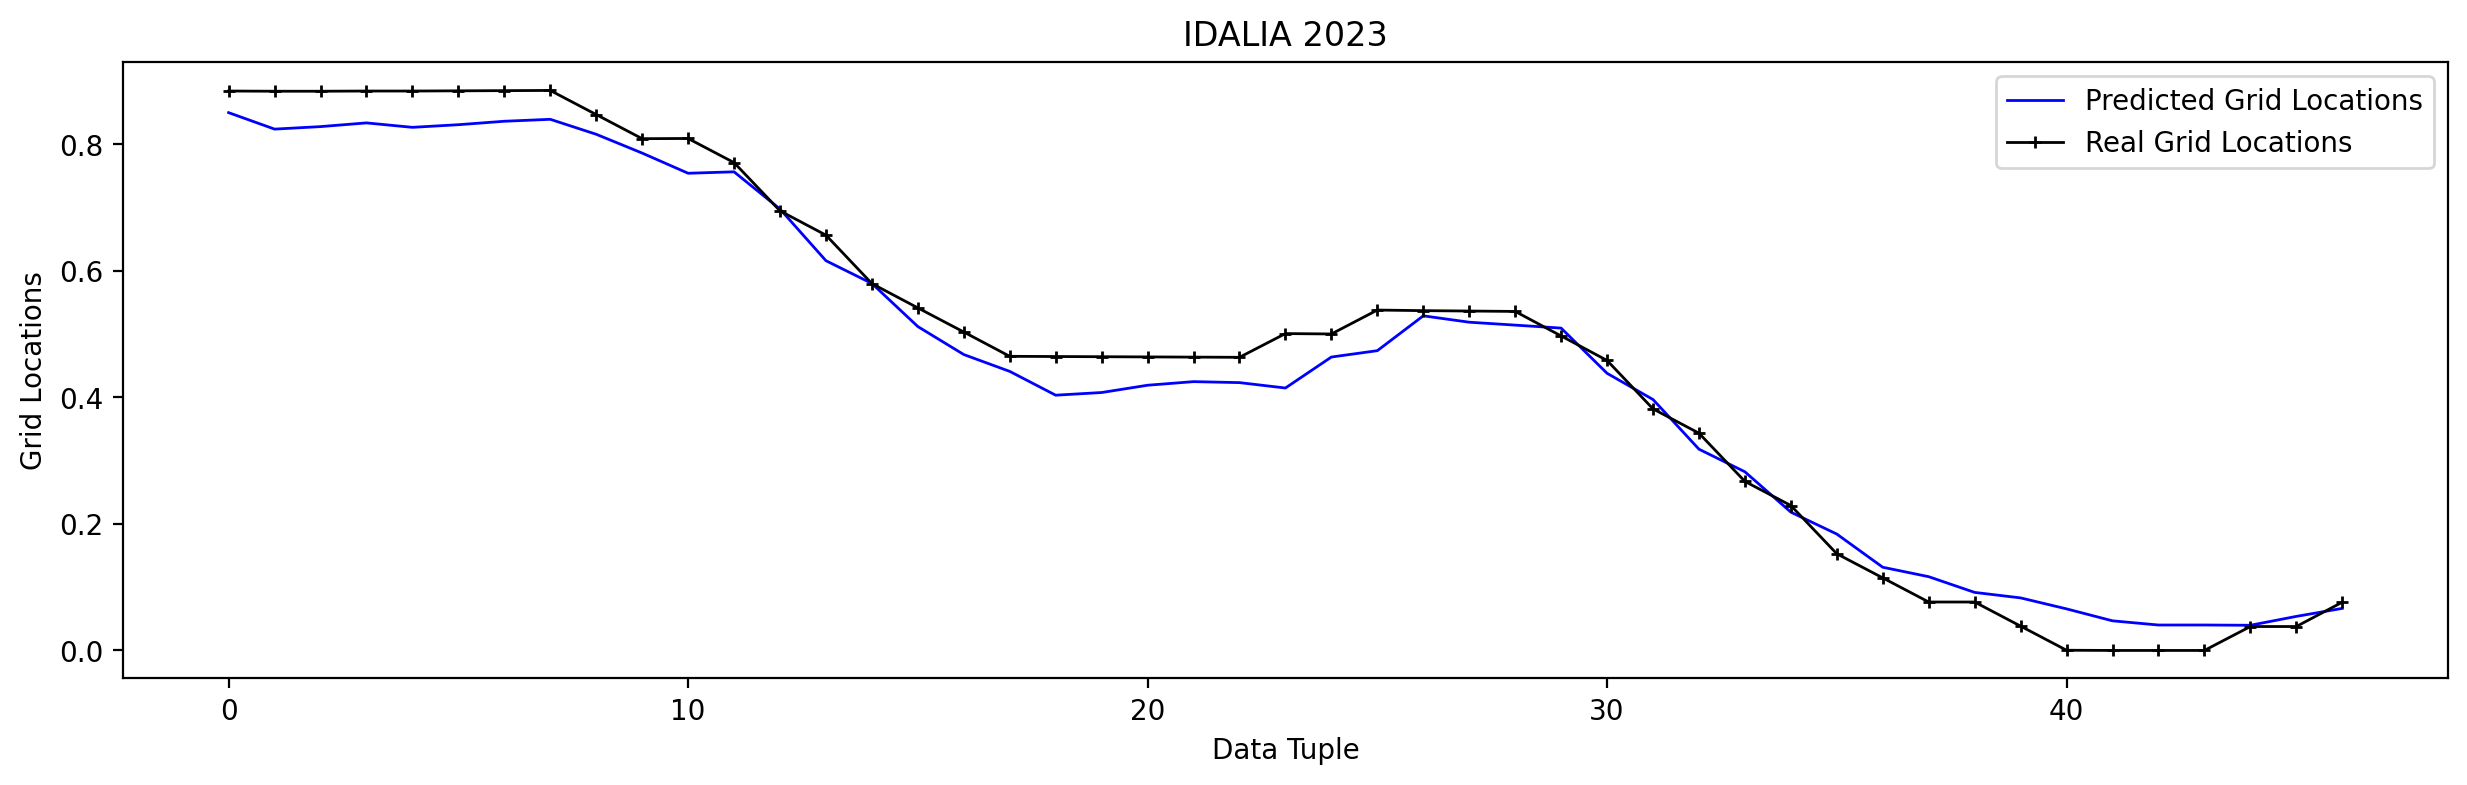

In [83]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred[:1000],
         linewidth=1,
         color='blue',
         label='Predicted Grid Locations')
plt.plot(y_test[:1000],
         linewidth=1,
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
# plt.savefig('denormalized_predictions')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')
plt.title('IDALIA 2023')
plt.legend(loc='upper right')
# plt.savefig('grid_accuracy.png')
plt.show()